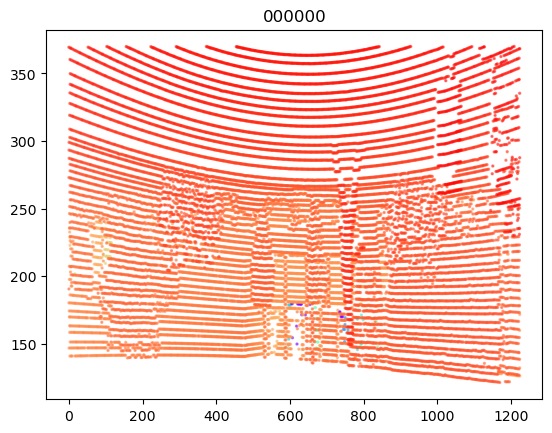

In [7]:
import torch
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from torchvision import transforms


# sn = int(sys.argv[1]) if len(sys.argv)>1 else 7 #default 0-7517
sn = 0
name = '%06d'%sn # 6 digit zeropadding
img = f'{name}.png'
binary = f'{name}.bin'
with open(f'{name}.txt','r') as f:
    calib = f.readlines()

# P2 (3 x 4) for left eye
P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3,4)
R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3,3)

# Add a 1 in bottom-right, reshape to 4 x 4
R0_rect = np.insert(R0_rect,3,values=[0,0,0],axis=0)
R0_rect = np.insert(R0_rect,3,values=[0,0,0,1],axis=1)
Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3,4)
Tr_velo_to_cam = np.insert(Tr_velo_to_cam,3,values=[0,0,0,1],axis=0)

# read raw data from binary
scan = np.fromfile(binary, dtype=np.float32).reshape((-1,4))

points = scan[:, 0:3] # lidar xyz (front, left, up)
# print(points.shape) # (115384, 3)

# TODO: use fov filter? 
velo = np.insert(points,3,1,axis=1).T
velo = np.delete(velo,np.where(velo[0,:]<0),axis=1)
cam = P2.dot(R0_rect.dot(Tr_velo_to_cam.dot(velo)))
cam = np.delete(cam,np.where(cam[2,:]<0),axis=1)

# get u,v,z
cam[:2] /= cam[2,:]
 
# print(cam.shape) # (3, 60675)
# print(cam[:2].shape) # (2, 60675)

# do projection staff
# plt.figure(figsize=(12,5),dpi=96,tight_layout=True)
png = mpimg.imread(img)
IMG_H,IMG_W,_ = png.shape

# print(png.shape) # (370, 1224, 3)

# # restrict canvas in range
# plt.axis([0,IMG_W,IMG_H,0])
# plt.imshow(png)

# filter point out of canvas
u,v,z = cam
u_out = np.logical_or(u<0, u>IMG_W)
v_out = np.logical_or(v<0, v>IMG_H)
outlier = np.logical_or(u_out, v_out)
cam = np.delete(cam,np.where(outlier),axis=1)
# print(cam.shape) --> (3, 20285)

# first_row = cam[1, :]
# min_value = np.min(first_row)
# max_value = np.max(first_row)

# print("Minimum value:", min_value)
# print("Maximum value:", max_value)

# generate color map from depth
u,v,z = cam
plt.scatter([u],[v],c=[z],cmap='rainbow_r',alpha=0.5,s=2)
plt.title(name)
plt.savefig(f'{name}_projected.png',bbox_inches='tight')
plt.show()





370 1224
Minimum value: 4.219317571710777
Maximum value: 72.72995055815288
torch.Size([1, 3, 20285])
torch.Size([1, 370, 1224])


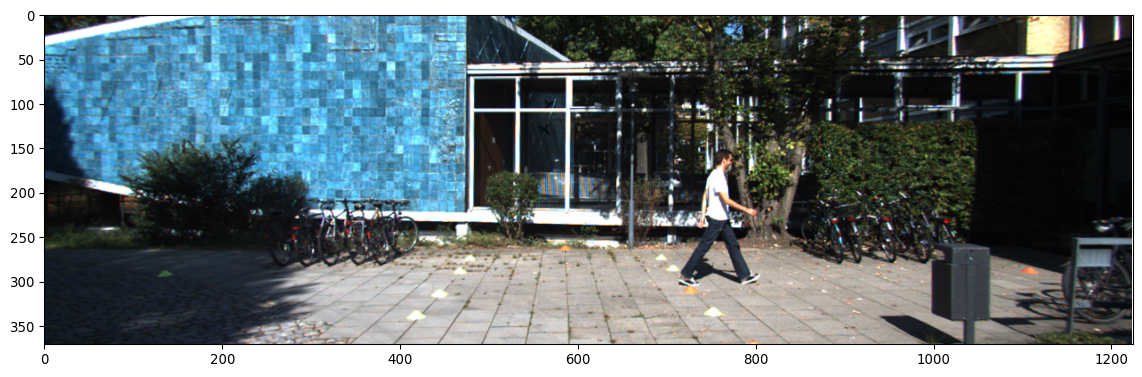

In [21]:
import torch
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from torchvision import transforms


sn = 0
name = '%06d' % sn
img = f'{name}.png'
binary = f'{name}.bin'
with open(f'{name}.txt', 'r') as f:
    calib = f.readlines()

P2 = np.array([float(x) for x in calib[2].strip('\n').split(' ')[1:]]).reshape(3, 4)
R0_rect = np.array([float(x) for x in calib[4].strip('\n').split(' ')[1:]]).reshape(3, 3)
R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0], axis=0)
R0_rect = np.insert(R0_rect, 3, values=[0, 0, 0, 1], axis=1)
Tr_velo_to_cam = np.array([float(x) for x in calib[5].strip('\n').split(' ')[1:]]).reshape(3, 4)
Tr_velo_to_cam = np.insert(Tr_velo_to_cam, 3, values=[0, 0, 0, 1], axis=0)

scan = np.fromfile(binary, dtype=np.float32).reshape((-1, 4))
points = scan[:, 0:3]
velo = np.insert(points, 3, 1, axis=1).T
velo = np.delete(velo, np.where(velo[0, :] < 0), axis=1)
cam = P2.dot(R0_rect.dot(Tr_velo_to_cam.dot(velo)))
cam = np.delete(cam, np.where(cam[2, :] < 0), axis=1)
cam[:2] /= cam[2, :] # (3, 60675)

plt.figure(figsize=(12, 5), dpi=96, tight_layout=True)
png = mpimg.imread(img)
IMG_H, IMG_W, _ = png.shape
plt.axis([0, IMG_W, IMG_H, 0])
plt.imshow(png)

print(IMG_H,IMG_W)


u_out = np.logical_or(u < 0, u > IMG_W)
v_out = np.logical_or(v < 0, v > IMG_H)
outlier = np.logical_or(u_out, v_out)
cam = np.delete(cam, np.where(outlier), axis=1)

u, v, depths = cam

first_row = cam[2, :]
min_value = np.min(first_row)
max_value = np.max(first_row)

print("Minimum value:", min_value)
print("Maximum value:", max_value)

convert_tensor = transforms.ToTensor()
points = convert_tensor(cam)
print(points.shape)

depths = torch.tensor(depths)

tensor_save = torch.zeros((1,IMG_H,IMG_W))

dim0, dim1, dim2 = points.shape
for i in range(dim2):
    y = points[0,0,i]
    y = y.long()
    x = points[0,1,i]
    x = x.long()
    z = depths[i]
    z = z.long()

    # if x>899 :
    #     x = 899
    # if y >1599:
    #     y = 1599
    # if z >50:
    #     print(x,y)
    tensor_save[0,x,y] = z

torch.save(tensor_save, f'{name}.pth')

print(tensor_save.shape)

# # Generate depth map
# depth_map = np.zeros((IMG_H, IMG_W)) # (370, 1224)
# depth_map[ v.astype(int), u.astype(int)] = z

# # Convert depth map to tensor
# depth_map_tensor = torch.from_numpy(depth_map).unsqueeze(0)
# print(depth_map_tensor.shape)

# # Save depth map tensor
# torch.save(depth_map_tensor, f'{name}_depth_map.pt')

# # Generate color map from depth
# plt.scatter([u], [v], c=[z], cmap='rainbow_r', alpha=0.5, s=2)
# plt.title(name)
# plt.savefig(f'{name}_projected2.png', bbox_inches='tight')
# plt.show()


torch.Size([1, 370, 1224])


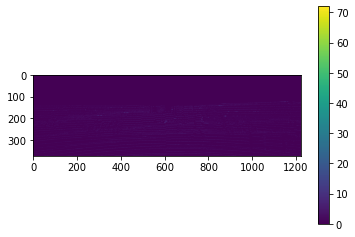

In [21]:
test = torch.load(f'{name}.pth')
# print(test.shape)

plt.imshow(test.view(370,1224)) # 需要给height，width顺序！
plt.colorbar()


In [26]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import torch

# Class for the calibration matrices for KITTI data
class Calibration:
    def __init__(self, calib_filepath):
        calibs = self.read_calib_file(calib_filepath)

        self.P = calibs['P2']
        self.P = np.reshape(self.P, [3,4])

        self.L2C = calibs['Tr_velo_to_cam']
        self.L2C = np.reshape(self.L2C, [3,4])

        self.R0 = calibs['R0_rect']
        self.R0 = np.reshape(self.R0,[3,3])

    @staticmethod
    def read_calib_file(filepath):
        data = {}
        with open(filepath, 'r') as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line)==0: continue
                key, value = line.split(':', 1)
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass
        return data
    
    # From LiDAR coordinate system to Camera Coordinate system
    def lidar2cam(self, pts_3d_lidar):
        n = pts_3d_lidar.shape[0]
        pts_3d_hom = np.hstack((pts_3d_lidar, np.ones((n,1))))
        pts_3d_cam_ref = np.dot(pts_3d_hom, np.transpose(self.L2C))
        pts_3d_cam_rec = np.transpose(np.dot(self.R0, np.transpose(pts_3d_cam_ref)))
        return pts_3d_cam_rec
    
    # From Camera Coordinate system to Image frame
    def rect2Img(self, rect_pts, img_width, img_height):
        n = rect_pts.shape[0]
        points_hom = np.hstack((rect_pts, np.ones((n,1))))
        points_2d = np.dot(points_hom, np.transpose(self.P)) # nx3
        points_2d[:,0] /= points_2d[:,2]
        points_2d[:,1] /= points_2d[:,2]
        
        mask = (points_2d[:,0] >= 0) & (points_2d[:,0] <= img_width) & (points_2d[:,1] >= 0) & (points_2d[:,1] <= img_height)
        mask = mask & (rect_pts[:,2] > 2)
        return points_2d[mask,0:2], mask

# From Github https://github.com/balcilar/DenseDepthMap
def dense_map(Pts, n, m, grid):
    ng = 2 * grid + 1
    
    mX = np.zeros((m,n)) + float("inf")
    mY = np.zeros((m,n)) + float("inf")
    mD = np.zeros((m,n))
    mX[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[0] - np.round(Pts[0])
    mY[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[1] - np.round(Pts[1])
    mD[np.int32(Pts[1]),np.int32(Pts[0])] = Pts[2]
    
    KmX = np.zeros((ng, ng, m - ng, n - ng))
    KmY = np.zeros((ng, ng, m - ng, n - ng))
    KmD = np.zeros((ng, ng, m - ng, n - ng))
    
    for i in range(ng):
        for j in range(ng):
            KmX[i,j] = mX[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmY[i,j] = mY[i : (m - ng + i), j : (n - ng + j)] - grid - 1 +i
            KmD[i,j] = mD[i : (m - ng + i), j : (n - ng + j)]
    S = np.zeros_like(KmD[0,0])
    Y = np.zeros_like(KmD[0,0])
    
    for i in range(ng):
        for j in range(ng):
            s = 1/np.sqrt(KmX[i,j] * KmX[i,j] + KmY[i,j] * KmY[i,j])
            Y = Y + s * KmD[i,j]
            S = S + s
    
    S[S == 0] = 1
    out = np.zeros((m,n))
    out[grid + 1 : -grid, grid + 1 : -grid] = Y/S
    return out
  

root = ""
image_dir = os.path.join(root, "./")
velodyne_dir = os.path.join(root, "./")
calib_dir = os.path.join(root, "./")
# Data id
cur_id = 0
# Loading the image
img = cv2.imread(os.path.join(image_dir, "%06d.png" % cur_id))
# Loading the LiDAR data
lidar = np.fromfile(os.path.join(velodyne_dir, "%06d.bin" % cur_id), dtype=np.float32).reshape(-1, 4)
# Loading Calibration
calib = Calibration(os.path.join(calib_dir, "%06d.txt" % cur_id))
# From LiDAR coordinate system to Camera Coordinate system
lidar_rect = calib.lidar2cam(lidar[:,0:3])
# From Camera Coordinate system to Image frame
lidarOnImage, mask = calib.rect2Img(lidar_rect, img.shape[1], img.shape[0])
# Concatenate LiDAR position with the intesity (3), with (2) we would have the depth
lidarOnImage = np.concatenate((lidarOnImage, lidar_rect[mask,2].reshape(-1,1)), 1)

# print(lidarOnImage.shape) --> (20285, 3)

out = dense_map(lidarOnImage.T, img.shape[1], img.shape[0], 5)
out_tensor = torch.unsqueeze(torch.from_numpy(out), dim=0)

torch.save(out_tensor, f'{name}_1.pth')

# print(out.shape) --> (370, 1224)
print(out_tensor.shape)
print(out.max(), out.min())
print(out[150,700])
# plt.figure(figsize=(20,40))
# plt.imsave("depth_map_%06d_5.png" % cur_id, out)


torch.Size([1, 370, 1224])
71.69175363239694 0.0
14.373986617956808


In [10]:
print(np.array_equal(cam,lidarOnImage.T))

False


In [11]:
print(cam.shape, lidarOnImage.T.shape)

(3, 20285) (3, 20285)


In [13]:
print(cam.max(),lidarOnImage.T.max())

1223.9031298968378 1223.903129896838


In [14]:
print(cam.min(),lidarOnImage.T.min())

0.21567763860066844 0.2156776386005871


In [25]:
print(tensor_save[0,200,750],out_tensor[0,200,750])

tensor(0.) tensor(8.4422, dtype=torch.float64)
